In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.cross_validation import train_test_split
from models.cascade_base import CascadeBase
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import time
import pydot
import lasagne

plt.style.use('ggplot')

%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [23]:
datasets = []
targets = []

for i in range(20):
    datasets.append(np.load('../data/clean_artificial/imgs_{}.npy'.format(str(i).zfill(4))).reshape(-1, 1, 512, 512))
    targets.append(np.load('../data/clean_artificial/masks_{}.npy'.format(str(i).zfill(4))).reshape(-1, 1, 512, 512))

dataset = np.vstack(datasets)
targets = np.vstack(targets)

track_targets = targets.copy()
track_targets[track_targets <=0] = 0

In [15]:
X_y = train_test_split(dataset, track_targets)

In [26]:
del X_y

## load pretrained on big images network

In [4]:
network = CascadeBase(img_shape=(512, 512),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=5e-1,
                      c_sub_objs=[1e-2, 5e-1, 1, 1],
                      c_sub_obj_cs=[1e-2, 5e-2, 1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2, 2],
                      num_filters=[1, 1, 3, 6],
                      filter_sizes=[1, 3, 3, 3],
                      l2_c=1e-4)

In [5]:
network.load('../weights', '3cascades_difficult_clear')

In [6]:
import theano
import theano.tensor as T

In [39]:
get_target = theano.function([network.targets], lasagne.layers.get_output(network.target_pool_layers[-1]))

def compute_recall_by_num_noise(dataset, targets, t):
    dataset_by_num_noise = {}

    for i in xrange(len(dataset)):
        num_noise = (dataset[i] * ((dataset[i] * (1 - targets[i])) == 5)).sum()

        if num_noise not in dataset_by_num_noise:
            dataset_by_num_noise[num_noise] = []

        dataset_by_num_noise[num_noise].append(i)
        
    recall_by_num_noise = {}

    for k, v in dataset_by_num_noise.items():
        recall_by_num_noise[k] = []

        for index in v:
            small_t = get_target(targets[index].reshape(1, 1, 512, 512))
            prediction = network.predict(dataset[index].reshape(1, 1, 512, 512).astype(np.float32))
            activation = prediction > t
            recall_by_num_noise[k].append((activation.sum(), small_t.sum(), (activation * small_t).sum()))
            
    return recall_by_num_noise, dataset_by_num_noise


def draw_recall_by_num_noise(recall_by_num_noises, thrs):
    for j, recall_by_num_noise in enumerate(recall_by_num_noises):
        counts, bins = np.histogram(recall_by_num_noise.keys())
        extended_bins = np.hstack((np.array([-np.inf]), bins, np.array([np.inf])))
        
        xs = []
        predictions = []
        targets = []
        right_answers = []
        
        early_stop = False
        for i in range(len(extended_bins) - 1):
            if early_stop:
                break
                
            examples = []
            for k, v in recall_by_num_noise.items():
                if k > extended_bins[i] and k <= extended_bins[i + 1]:
                    examples += v
            
            if not examples:
                for k, v in recall_by_num_noise.items():
                    if k > extended_bins[i]:
                        examples += v
                
                early_stop = True
           
            xs.append(extended_bins[i + 1] / 512**2)
            examples = np.array(examples)
    
            predictions.append(examples[:, 0].mean())
            targets.append(examples[:, 1].mean())
            right_answers.append(examples[:, 2].mean())
            
            if early_stop:
                break
        
        plt.plot(xs, predictions, label= 'P')
        plt.plot(xs, targets, label= 'TP + TN')
        plt.plot(xs, right_answers, label='TP')
        plt.legend(loc='best')
        plt.title('Recall = ' + str(thrs[j]))
        plt.xlabel('noise per cent')
        plt.yscale('log')
        plt.show()
        
        
def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]
        
        
def draw_precision_by_num_noise(dataset_by_num_noises, thrs):
    for j, dataset_by_num_noise in enumerate(dataset_by_num_noises):
        counts, bins = np.histogram(dataset_by_num_noise.keys())
        extended_bins = np.hstack((np.array([-np.inf]), bins, np.array([np.inf])))
        
        xs = []
        precisions = []
        
        early_stop = False
        for i in range(len(extended_bins) - 1):
            if early_stop:
                break
                
            indicies = []
            for k, v in dataset_by_num_noise.items():
                if k > extended_bins[i] and k <= extended_bins[i + 1]:
                    indicies += v
            
            if not indicies:
                for k, v in dataset_by_num_noise.items():
                    if k > extended_bins[i]:
                        indicies += v
                
                early_stop = True
           
            xs.append(extended_bins[i + 1] / 512**2)
                        
            if len(dataset[indicies]) > 1000:
                precision_train = 0
                num_epochs = 0
                
                for batch in iterate_minibatches(dataset[indicies], targets[indicies], 1000):
                    precision_train += network.evaluate(batch[0], batch[1])['precision']
                    num_epochs += 1
                    
                precisions.append(precision_train / float(num_epochs))
            else:
                precisions.append(network.evaluate(dataset[indicies], targets[indicies])['precision'])
            
            if early_stop:
                break
        
        plt.plot(xs, precisions, label= 'precision ' + str(thrs[j]))
    plt.legend(loc='best')
    plt.xlabel('noise per cent')
    plt.show()

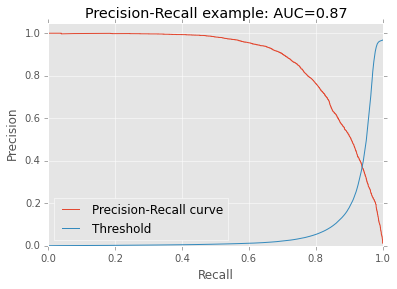

In [70]:
x_val = dataset[:1000]
y_val = targets[:1000]

prediction = network.predict(x_val)
target = get_target(y_val)

precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())
average_precision = average_precision_score(target.ravel(), prediction.ravel())

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc='best')
plt.show()

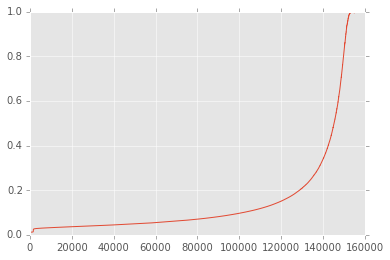

In [18]:
plt.plot(precision)

In [24]:
precision[np.max(np.where(recall >= 0.99))]

0.10713164093169328

In [71]:
thr[np.min(np.where(recall <= 0.99))]

0.014698416

In [21]:
recall[np.max(np.where(recall >= 0.99))]

0.99008344418914018

In [27]:
complexity, max_complexity, miltipliers, constants = network.compute_complexity()
result = complexity[0] * network.input_X.shape[0]

for i in range(len(complexity) - 1):
    result += complexity[i + 1] * miltipliers[i] + 10 * constants[i]
    
estimate_complexity = theano.function([network.input_X, network.targets], result / complexity[0] / network.input_X.shape[0])

In [29]:
estimate_complexity(x_val, y_val)

array(1.1623287506103515)

In [28]:
network.evaluate(x_val, y_val)

{'accuracy': array(0.9953720703125),
 'complexity_parts': array([ 1.        ,  0.01104511,  0.00515554,  0.00738666]),
 'loss': array(0.004200671333819628, dtype=float32),
 'obj': array(0.014420760627344058),
 'precision': array(0.6673620343208313),
 'recall': array(0.8511307239532471, dtype=float32),
 'sub_loss': array(0.00357682048343122, dtype=float32),
 'total_complexity': array(0.00839022885909638)}

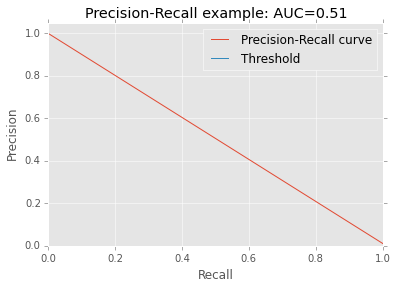

In [48]:
prediction = get_target(x_val).ravel()
target = get_target(y_val).ravel()

precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())
average_precision = average_precision_score(target.ravel(), prediction.ravel())

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc='best')
plt.show()

In [21]:
precision

array([ 0.01168449,  1.        ])

/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


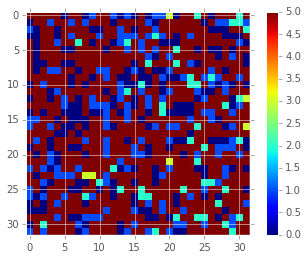

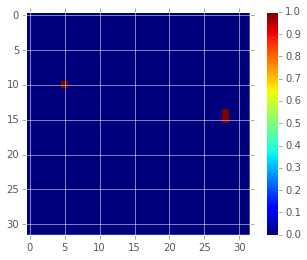

In [31]:
plt.imshow(get_target(x_val)[8, 0], interpolation='none')
plt.colorbar()
plt.show()

plt.imshow(get_target(y_val)[8, 0], interpolation='none')
plt.colorbar()
plt.show()

In [73]:
recall_by_num_noise99, dataset_by_num_noise99 = compute_recall_by_num_noise(dataset, targets, thr[np.max(np.where(recall >= 0.99))])
recall_by_num_noise95, dataset_by_num_noise95 = compute_recall_by_num_noise(dataset, targets, thr[np.max(np.where(recall >= 0.95))])
recall_by_num_noise90, dataset_by_num_noise90 = compute_recall_by_num_noise(dataset, targets, thr[np.max(np.where(recall >= 0.90))])

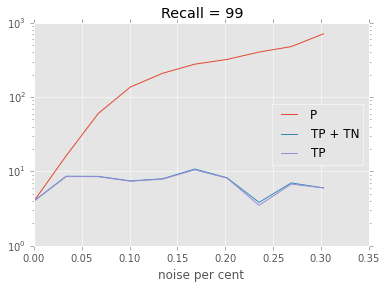

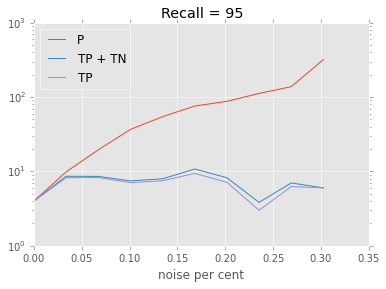

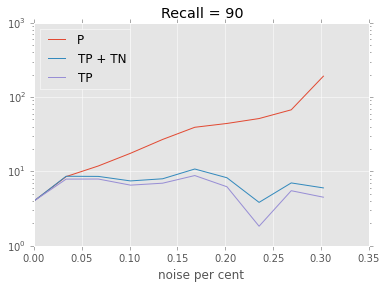

In [74]:
draw_recall_by_num_noise([recall_by_num_noise99,
                          recall_by_num_noise95,
                          recall_by_num_noise90], [99, 95, 90])

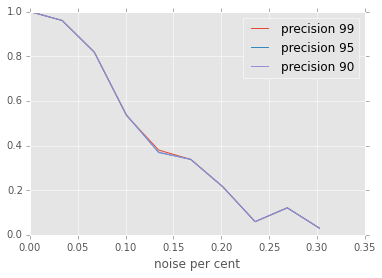

In [40]:
draw_precision_by_num_noise([dataset_by_num_noise99,
                             dataset_by_num_noise95,
                             dataset_by_num_noise90], [99, 95, 90])

In [76]:
import pickle

with open('../weights/recall_by_num_noise.pkl', 'wb') as f:
    pickle.dump([recall_by_num_noise99,
                 recall_by_num_noise95,
                 recall_by_num_noise90], f)

In [85]:
with open('../weights/dataset_by_num_noise.pkl', 'wb') as f:
    pickle.dump([dataset_by_num_noise99,
                 dataset_by_num_noise95,
                 dataset_by_num_noise90], f)

In [9]:
import pickle

with open('../weights/dataset_by_num_noise.pkl') as f:
    dataset_by_num_noise99, dataset_by_num_noise95, dataset_by_num_noise90 = pickle.load(f)